# Lab 6
## Author: Konstantin Yakovlev

## Description:
Here is the implementation of ODE-RNN. We considered two cases of a dynamic: pendulum and 2 fully connected layers. 
Required torchdiffeq library and WISDM dataset.

In [212]:
!pip install torchdiffeq

In [213]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from torchdiffeq import odeint

In [214]:
df = pd.read_csv('wisdm-dataset/raw/watch/accel/data_1601_accel_watch.txt', header=None)
df.head()

,0,1,2,3,4,5
0,1601,A,1896411611733301,-2.969708,-1.949329,10.726623;
1,1601,A,1896411661695801,-3.486855,-2.420987,11.660361;
2,1601,A,1896411711658874,-2.826056,-2.854338,9.792884;
3,1601,A,1896411761623926,-3.307290,-3.076998,9.926959;
4,1601,A,1896411811593717,-3.996820,-2.847155,9.280524;


In [5]:
df = df[df.iloc[:, 1] == 'A']

In [6]:
df = df.iloc[:, 2:]
df.head()

,2,3,4,5
0,1896411611733301,-2.969708,-1.949329,10.726623;
1,1896411661695801,-3.486855,-2.420987,11.660361;
2,1896411711658874,-2.826056,-2.854338,9.792884;
3,1896411761623926,-3.307290,-3.076998,9.926959;
4,1896411811593717,-3.996820,-2.847155,9.280524;


In [7]:
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: float(x[:-1]))
scaler = StandardScaler()
X = scaler.fit_transform(df)

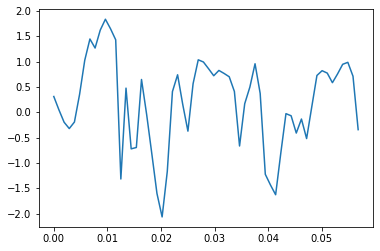

In [165]:
W = 60
t_space = X[:W, 0] - X[:W, 0].min()
x_space = X[:W, 2]
plt.plot(t_space, x_space)

### Torch implementation

In [215]:
class AccelDataset(torch.utils.data.Dataset):
    def __init__(self, t_array, a_array):
        assert t_array.shape == a_array.shape, "Shape must be the same"
        self.t_array = t_array
        self.a_array = a_array
    
    def __getitem__(self, idx):
        return torch.tensor(self.t_array[idx]).float(), torch.tensor(self.a_array[idx]).float()
    
    def __len__(self):
        return self.t_array.shape[0]

def collate(batch):
    '''
        Params:
        batch: list of pairs of tensors [(t, x), ...]
    '''
    t = [el[0] for el in batch]
    x = [el[1] for el in batch]
    return torch.stack(t), torch.stack(x).unsqueeze(1)
    
ds = AccelDataset(t_space, x_space)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, collate_fn=collate)
### TEST
for batch in dl:
    print(batch[0].shape)
    break

torch.Size([16])


Given pendulum equation:

$\frac{d^2\phi}{dt^2} + \theta\sin\phi = 0 \Rightarrow$
$\frac{d}{dt}\begin{pmatrix}\phi_1\\ \phi\end{pmatrix} = \begin{pmatrix}-\theta\sin\phi\\\phi_1\end{pmatrix}$

### ODE-RNN

In [200]:
class ODE_RNN(nn.Module):
    def __init__(self, hidden_size, pendulum=True):
        super(ODE_RNN, self).__init__()
        self.pendulum = pendulum
        self.hx = torch.randn(1, hidden_size) # (batch, hidden_size)
        self.cx = torch.randn(1, hidden_size)
        self.rnn = nn.LSTMCell(2, hidden_size) # (input_size, hidden_size)
        self.net = nn.Sequential(
            nn.Linear(2, 2),
                nn.Tanh(),
                nn.Linear(2, 2)
        )
        self.theta = nn.Parameter(torch.tensor(0.1))
        self.to_2d = nn.Linear(hidden_size, 2)
        self.to_hidden = nn.Linear(2, hidden_size)
        
        self.hidden_to_output = nn.Linear(hidden_size, 1)
        
        
    def func(self, t, x):
        '''dynamic'''
        if self.pendulum: 
            return torch.cat([-self.theta * torch.sin(x[:, 0]), x[:, 1]], dim=-1)
        return self.net(x)
    
    def forward(self, t_arr, x_arr):
        output = []
        hx = self.hx
        cx = self.cx
        for i in range(1, t_arr.shape[0]):
            ode_solution = odeint(self.func, self.to_2d(hx), t_arr[i - 1:i + 1])[-1]
            hx = self.to_hidden(ode_solution)
            hx, cx = self.rnn(ode_solution, (hx, cx))
            output.append(self.hidden_to_output(hx)[0])
        return torch.stack(output, dim=0)
### TEST
t_arr = torch.rand(5).sort()[0]
t_arr[0] = 0
print('t', t_arr)
x_arr = torch.sin(t_arr)
print(x_arr)

criterion = nn.MSELoss()
ode_rnn = ODE_RNN(20)
output = ode_rnn(t_arr, x_arr)
print('x_arr shape', x_arr.shape)
criterion(output.view(-1), x_arr[1:])

t tensor([0.0000, 0.4202, 0.4824, 0.5711, 0.9084])
tensor([0.0000, 0.4079, 0.4639, 0.5406, 0.7885])
x_arr shape torch.Size([5])


tensor(0.0775, grad_fn=<MseLossBackward>)

In [209]:
### Training
t_arr = torch.tensor([ds[i][0] for i in range(len(ds))])
x_arr = torch.tensor([ds[i][1] for i in range(len(ds))])
def train(model):
    train_loss = []
    print(len(ds))

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ode_rnn.parameters(), lr=8e-3)

    for epoch in range(500):
        output = ode_rnn(t_arr, x_arr)
        loss = criterion(output.view(-1), x_arr[1:])
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, loss {loss.item():.4}')
    return train_loss
# train pandulum
ode_rnn = ODE_RNN(20, False)
train_loss = train(ode_rnn)

60
Epoch 0, loss 0.9988
Epoch 20, loss 0.7914
Epoch 40, loss 0.7893
Epoch 60, loss 0.7884
Epoch 80, loss 0.7879
Epoch 100, loss 0.7865
Epoch 120, loss 0.7752
Epoch 140, loss 0.5599
Epoch 160, loss 0.6512
Epoch 180, loss 0.4149
Epoch 200, loss 0.5243
Epoch 220, loss 0.3469
Epoch 240, loss 0.387
Epoch 260, loss 0.3615
Epoch 280, loss 0.2856
Epoch 300, loss 0.3752
Epoch 320, loss 0.2461
Epoch 340, loss 0.2029
Epoch 360, loss 0.7353
Epoch 380, loss 0.2214
Epoch 400, loss 0.4749
Epoch 420, loss 0.1824
Epoch 440, loss 0.1903
Epoch 460, loss 0.1923
Epoch 480, loss 0.1611


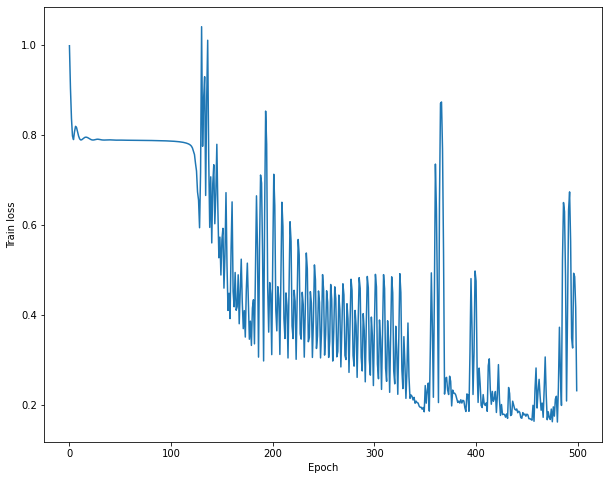

In [211]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Train loss')
# plt.savefig('report/sections/example/figures/dense_train.png')
plt.show()

torch.Size([80])
val loss tensor(1.3758, dtype=torch.float64)


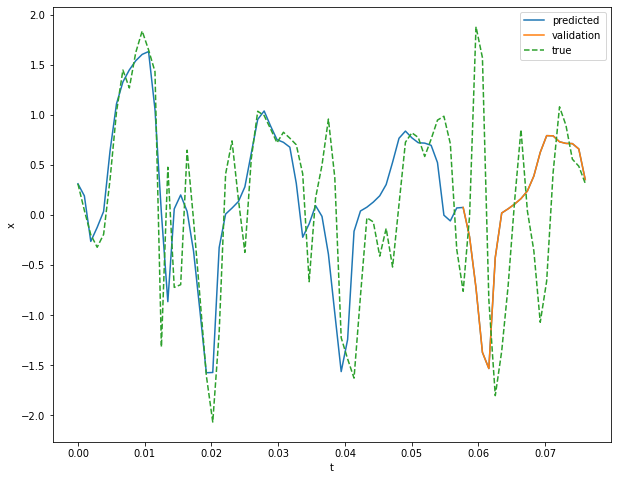

In [203]:
### Predict
t_space_valid = X[W:W + 20, 0] - X[:W, 0].min()
x_space_valid = X[W:W + 20, 2]

x_arr_valid = torch.tensor(x_space_valid)
t_arr_valid = torch.tensor(t_space_valid)

x_arr_total = torch.cat([x_arr, x_arr_valid])
t_arr_total = torch.cat([t_arr, t_arr_valid])

with torch.no_grad():
    output = ode_rnn(t_arr_total, x_arr_total).squeeze()
output = torch.cat([x_arr_total[0].reshape(1), output])
print(output.shape)
print('val loss', criterion(x_arr_valid, output[-t_arr_valid.shape[0]:]))

plt.figure(figsize=(10, 8))
plt.xlabel('t')
plt.ylabel('x')

plt.plot(t_arr_total.numpy(), output.numpy(), label='predicted')
plt.plot(t_arr_valid.numpy(), output[-t_arr_valid.shape[0]:].numpy(), label='validation')
plt.plot(t_arr_total.numpy(), x_arr_total.numpy(), '--', label='true')
plt.legend()
# plt.savefig('report/sections/example/figures/pendulum.png')
# plt.savefig('report/sections/example/figures/dense.png')